<a href="https://colab.research.google.com/github/Mohamed-Ibrahim-01/heart-sound-classificatoin/blob/master/heart_sound_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U -q PyDrive2

     |████████████████████████████████| 55 kB 4.0 MB/s 
     |████████████████████████████████| 4.0 MB 14.1 MB/s 


In [34]:
import numpy as np
import pandas as pd
import librosa.display
import zipfile
import matplotlib.pyplot as plt
import shutil
import glob
import os
import re
from pathlib import Path

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
MAX_DURATION = 2000
BASE_DIR = os.getcwd()

PascalInfo = {
    "NAME" : "pascal",
    "ZIP_NAME" : "Pascal.zip",
    "DRIVE_ID" : "1nkSqb_B-uqv7-zka9HlmAcLkoDET2mqk",
    "ZIP_PATH" : ""
}

Dirs = {
    "BASE" : BASE_DIR,
    "DATASETS" : f"{BASE_DIR}{os.sep}datasets",
}


In [6]:
def download_from_drive(file_id, file_name):
    curr_dir = os.getcwd()
    drive_file = drive.CreateFile({'id': file_id})
    drive_file.GetContentFile(file_name)
    downloaded_path = f"{curr_dir}{os.sep}{file_name}"
    return downloaded_path

PascalInfo["ZIP_PATH"] = download_from_drive(PascalInfo["DRIVE_ID"], PascalInfo["ZIP_NAME"])

In [46]:
def load_dataset(dataset_info):
    name, zip_path = dataset_info['NAME'], dataset_info["ZIP_PATH"]
    dataset_dir = f"{Dirs['DATASETS']}{os.sep}{name}"
    if(os.path.exists(dataset_dir)):
        shutil.rmtree(dataset_dir)
    Path(dataset_dir).mkdir(parents=True, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_dir)
    return dataset_dir

def folder_label(folder_path):
    label = re.findall(r"murmur|normal|extrastole", folder_path.lower())
    if len(label) == 0:
        return "other"
    return label[0] if label[0] != "extrastole" else "extrasystole"

def load_pascal():
    pascal_dir = load_dataset(PascalInfo)
    zip_files = glob.glob(f'{pascal_dir}{os.sep}*.zip')
    for zip_path in zip_files:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(pascal_dir)
    folders = glob.glob(f'{pascal_dir}{os.sep}*{os.sep}')
    folders.pop()
    sounds = []
    for folder_path in folders:
        label = folder_label(folder_path)
        if label not in {"murmur", "normal", "extrasystole"}:
            continue
        wav_files = glob.glob(f'{folder_path}{os.sep}*.wav')
        for sound_path in wav_files:
            sound_name = os.path.basename(sound_path).split(".")[0]
            sounds.append([sound_name, sound_path, label])
    return pd.DataFrame(sounds, columns=["name", "path", "label"])

pascal_df = load_pascal()
pascal_df.head()


,name,path,label
0,184_1308073010307_A,/content/datasets/pascal/Btraining_extrastole/...,extrasystole
1,153_1306848820671_C,/content/datasets/pascal/Btraining_extrastole/...,extrasystole
2,179_1307990076841_C,/content/datasets/pascal/Btraining_extrastole/...,extrasystole
3,198_1308141739338_B,/content/datasets/pascal/Btraining_extrastole/...,extrasystole
4,275_1310990852160_B,/content/datasets/pascal/Btraining_extrastole/...,extrasystole


In [51]:
dataset_df = pascal_df
normal_df = dataset_df[dataset_df["label"] == "normal"]
murmur_df = dataset_df[dataset_df["label"] == "murmur"]
extrasystole_df = dataset_df[dataset_df["label"] == "extrasystole"]

print("Dataset B: ", dataset_df.shape, list(dataset_df.columns))
print("Normal: ", normal_df.shape, "Murmur: ", murmur_df.shape,  "Extrasystole: ", extrasystole_df.shape)

Dataset B:  (312, 3) ['name', 'path', 'label']
Normal:  (200, 3) Murmur:  (66, 3) Extrasystole:  (46, 3)


In [53]:
random_normal_sample = normal_df.iloc[1]["path"]
random_extrasystole_sample = extrasystole_df.iloc[1]["path"]

assert(os.path.exists(random_normal_sample))
assert(os.path.exists(random_extrasystole_sample))

In [54]:
def plot_hs(path, dur=1.5):
    y, sr = librosa.load(path, sr=8000, duration=dur)
    fig, ax = plt.subplots(nrows=1, figsize=(20,4))
    librosa.display.waveshow(y, sr=sr, ax=ax)
    ax.set(title=f'{path.split("/")[-1]}')
    plt.show()
    return (y, sr)

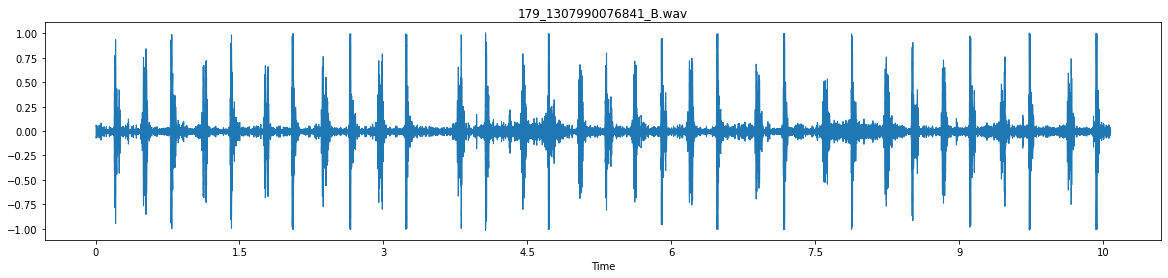

In [55]:
from IPython.display import Audio
y, sr = plot_hs(random_normal_sample, dur=MAX_DURATION)
Audio(data=y, rate=sr)

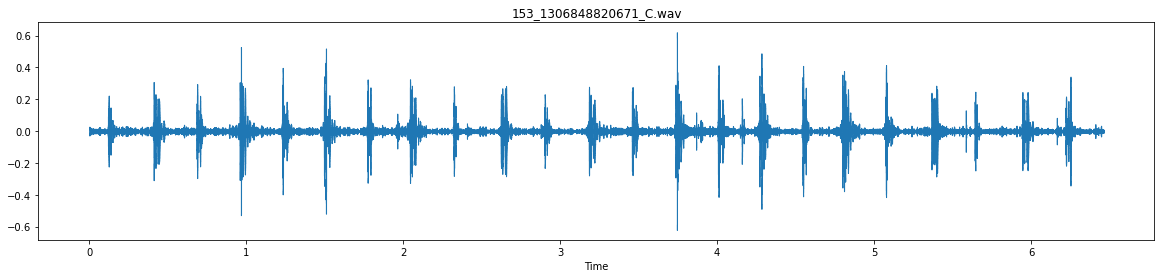

In [57]:
from IPython.display import Audio
y, sr = plot_hs(random_extrasystole_sample, dur=MAX_DURATION)
Audio(data=y, rate=sr)